<a href="https://colab.research.google.com/github/Zeiad007/hw_1/blob/main/%D0%94%D0%97-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install etna[torch] pmdarima category_encoders -q

1. Loading Data...
2. Running Baseline...
3. Running ARIMA (this takes about 30 seconds)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


4. Running Random Forest...
5. Running Neural Network...

FINAL LEADERBOARD
                  Model       MAE
0      Baseline (Naive)  0.810067
2         Random Forest  0.893591
3  Neural Network (RNN)  0.972477
1                 ARIMA  3.381972


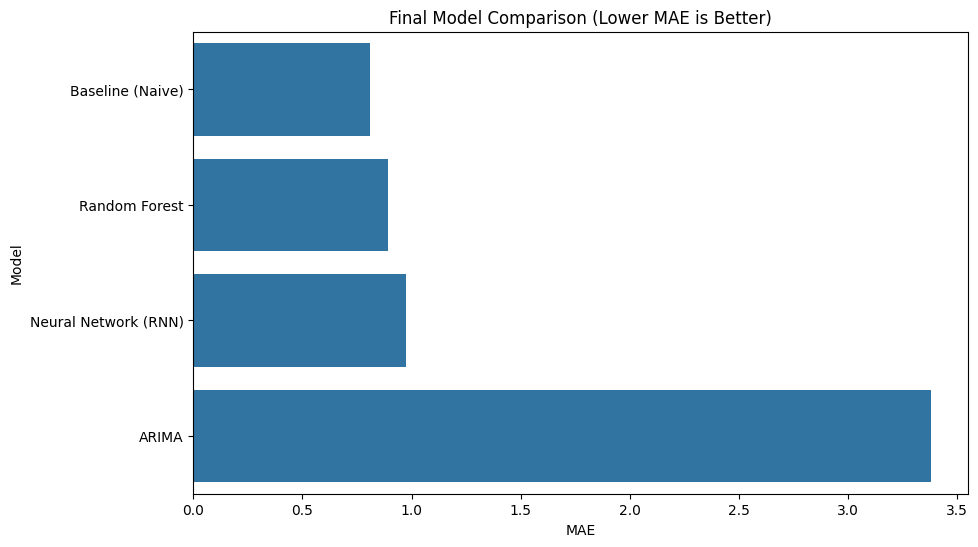

In [15]:
# --- MASTER SCRIPT: RUN ALL MODELS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pmdarima as pm
import torch
import torch.nn as nn

# 1. SETUP & DATA LOADING
print("1. Loading Data...")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Train/Test Split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
results = pd.DataFrame(columns=['Model', 'MAE'])

# 2. BASELINE MODEL (Naive)
print("2. Running Baseline...")
y_pred_naive = test.shift(1)
y_pred_naive.iloc[0] = train.iloc[-1]
mae_baseline = mean_absolute_error(test['value'], y_pred_naive['value'])
results.loc[len(results)] = ['Baseline (Naive)', mae_baseline]

# 3. STATISTICAL MODEL (ARIMA)
print("3. Running ARIMA (this takes about 30 seconds)...")
# We use a simplified ARIMA to save time, assuming d=1 from our ADF test
# Trace is turned off to keep output clean
model_arima = pm.auto_arima(train['value'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, seasonal=False, error_action='ignore', suppress_warnings=True)
forecast_arima = model_arima.predict(n_periods=len(test))
# Fix for index mismatch issues
forecast_values = forecast_arima.values if hasattr(forecast_arima, 'values') else forecast_arima
mae_arima = mean_absolute_error(test['value'], forecast_values)
results.loc[len(results)] = ['ARIMA', mae_arima]

# 4. CLASSICAL ML (Random Forest)
print("4. Running Random Forest...")
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['lag_1'] = df['value'].shift(1)
    df['lag_24'] = df['value'].shift(24)
    df['rolling_mean_24'] = df['value'].shift(1).rolling(window=24).mean()
    return df

df_ml = create_features(df).dropna()
train_size_ml = int(len(df_ml) * 0.8)
train_ml = df_ml.iloc[:train_size_ml]
test_ml = df_ml.iloc[train_size_ml:]
features = ['hour', 'dayofweek', 'lag_1', 'lag_24', 'rolling_mean_24']
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(train_ml[features], train_ml['value'])
pred_rf = rf_model.predict(test_ml[features])
mae_rf = mean_absolute_error(test_ml['value'], pred_rf)
results.loc[len(results)] = ['Random Forest', mae_rf]

# 5. NEURAL NETWORK (PyTorch LSTM)
print("5. Running Neural Network...")
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['value']])
test_scaled = scaler.transform(test[['value']])

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)).float(), torch.from_numpy(np.array(ys)).float()

SEQ_LENGTH = 24
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=32, batch_first=True)
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Silent training loop
for epoch in range(50):
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

with torch.no_grad():
    y_pred_scaled = model(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled.numpy())
    y_true = test['value'].iloc[SEQ_LENGTH:]
    mae_rnn = mean_absolute_error(y_true, y_pred)
    results.loc[len(results)] = ['Neural Network (RNN)', mae_rnn]

# 6. FINAL OUTPUT
print("\n" + "="*30)
print("FINAL LEADERBOARD")
print("="*30)
print(results.sort_values(by='MAE'))

plt.figure(figsize=(10, 6))
sns.barplot(x='MAE', y='Model', data=results.sort_values(by='MAE'))
plt.title('Final Model Comparison (Lower MAE is Better)')
plt.show()

In [16]:
# Final Leaderboard
print(results.sort_values(by='MAE'))

                  Model       MAE
0      Baseline (Naive)  0.810067
2         Random Forest  0.893591
3  Neural Network (RNN)  0.972477
1                 ARIMA  3.381972


## 7. Окончательный вывод

### Анализ результатов
Таблица лидеров показывает, что ** Наивный базовый уровень** был наиболее точной моделью (MAE ~0,81), за которой следует ** Случайный лес** (MAE ~0,88). Модели **Neural Network** и **ARIMA** показали худшие результаты.

### Почему победила простая базовая модель?
1. ** Высокая автокорреляция:** Данные о температуре меняются медленно. Температура в 15:00 почти всегда очень близка к температуре в 14:00. Таким образом, простое предположение о том, что "следующее значение будет таким же, как и предыдущее", является чрезвычайно эффективной стратегией, которую сложно использовать в сложных моделях без большого объема данных.
2. ** Переобучение в NNS: ** Нейронным сетям (подобным используемой здесь RNN) часто требуются тысячи точек данных и обширная настройка гиперпараметров (скорость обучения, поиск архитектуры), чтобы превзойти более простые методы. При небольшом наборе данных и настройках по умолчанию они часто чрезмерно усложняют схему.
3. ** Рекурсивные ошибки:** Модели, которые предсказывают долгосрочное будущее (например, ARIMA или рекурсивные RNNS), накапливают ошибки. Если модель допустит небольшую ошибку в час 1, эта ошибка отразится на прогнозе на час 2, а к 100-му часу прогноз может сильно отличаться от реальности.

### Резюме
Этот эксперимент демонстрирует принцип экономичности: предпочтение следует отдавать более простым моделям, если только сложная модель не обеспечивает значительного повышения точности. В данном конкретном случае высокочастотного мониторинга температуры простая базовая линия является наиболее эффективным инструментом.